## Streaming Sourmash

This notebook demonstrates how to use goetia to perform a streaming analysis of sourmash minhash signatures. Boink includes the sourmash C++ header and exposes it with cpppy, and wraps it so it can be used with goetia's sequence processors. This enables a simple way to perform fast streaming signature analysis in Python.

In [1]:
# First, import the necessary libraries

In [2]:
from goetia import libgoetia
from goetia.alphabets import DNAN_SIMPLE
from goetia.signatures import SourmashSignature

from sourmash import load_one_signature, MinHash
import screed

from ficus import FigureManager
import seaborn as sns
import numpy as np

### The Signature Class

The goetia `SourmashSignature.Signature` is derived from `sourmash::MinHash`, and so follows the same interface. This signature will contain 10000 hashes at a $K$ of 31.

In [3]:
all_signature = SourmashSignature.Signature.build(10000, 31, False, False, False, 42, 0)

### The Signature Processor

`SourmashSignature` contains its own sequence processor. This processor is iterable; it will process the given sequences in chunks given by `fine_interval`. The default fine interval is 10000. Alternatively, we can call `process` to consume the entire sample.

In [4]:
processor = SourmashSignature.Processor.build(all_signature)

Let's get some data. We'll start with something small, an ecoli sequencing run.

In [5]:
!curl -L https://osf.io/wa57n/download > ecoli.1.fastq.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   459  100   459    0     0    816      0 --:--:-- --:--:-- --:--:--   815
100  119M  100  119M    0     0  22.3M      0  0:00:05  0:00:05 --:--:-- 29.9MM    0     0  9290k      0  0:00:13  0:00:02  0:00:11 21.5M


In [6]:
!curl -L https://osf.io/khqaz/download > ecoli.2.fastq.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   459  100   459    0     0    972      0 --:--:-- --:--:-- --:--:--   974
100  122M  100  122M    0     0  16.9M      0  0:00:07  0:00:07 --:--:-- 20.2M 17.9M      0  0:00:06  0:00:06 --:--:-- 22.5M


#### Consuming Files

The processor can handle single or paired mode natively. There's nothing special to be done with paired reads for sourmash, so the paired mode just consumes each sequence in the pair one after the other. This is a full sequencing run of ~3.5 million sequences; it should take about ten-to-twenty seconds to consume. 

In [7]:
%time processor.process('ecoli.1.fastq.gz', 'ecoli.2.fastq.gz')

CPU times: user 16.1 s, sys: 44.1 ms, total: 16.1 s
Wall time: 16.1 s


3714646

If sourmash is installed, we can convert the signature to a `sourmash.MinHash` object to do further analysis.

In [8]:
all_mh = all_signature.to_sourmash()

In [9]:
all_mh

#### Chunked Processing

Now let's do it in chunked mode. We'll print info on the medium interval, which is contained in the state object.

In [10]:
chunked_signature = SourmashSignature.Signature.build(10000, 31, False, False, False, 42, 0)
processor = SourmashSignature.Processor.build(chunked_signature, 10000, 250000)

for n_reads, n_skipped, state in processor.chunked_process('ecoli.1.fastq.gz', 'ecoli.2.fastq.gz'):
    if state.medium:
        print('Processed', n_reads, 'sequences.')

Processed 250000 sequences.
Processed 500000 sequences.
Processed 750000 sequences.
Processed 1000000 sequences.
Processed 1250000 sequences.
Processed 1500000 sequences.
Processed 1750000 sequences.
Processed 2000000 sequences.
Processed 2250000 sequences.
Processed 2500000 sequences.
Processed 2750000 sequences.
Processed 3000000 sequences.
Processed 3250000 sequences.
Processed 3500000 sequences.


The similarity should be exact...

In [11]:
chunked_mh = chunked_signature.to_sourmash()
chunked_mh.similarity(all_mh)

1.0

### Streaming Distance Calculation

Using the chunked processor for reporting is a bit boring. A more interesting use-case is is to track within-sample distances -- streaming analysis. We'll write a quick function to perform this analysis

In [12]:
def sourmash_stream(left, right, N=1000, K=31):
    distances = []
    times = []

    streaming_sig = SourmashSignature.Signature.build(N, K, False, False, False, 42, 0)
    # We'll set the medium_interval to 250000
    processor = SourmashSignature.Processor.build(streaming_sig, 10000, 250000)

    # Calculate a distance at each interval. The iterator is over fine chunks.
    prev_mh = None
    for n_reads, _, state in processor.chunked_process(left, right):
        curr_mh = streaming_sig.to_sourmash()
        if prev_mh is not None:
            distances.append(prev_mh.similarity(curr_mh))
            times.append(n_reads)
        prev_mh = curr_mh

        if state.medium:
            print(n_reads, 'reads.')
    
    return np.array(distances), np.array(times), streaming_sig

In [13]:
distances_small, times_small, mh_small = sourmash_stream('ecoli.1.fastq.gz', 'ecoli.2.fastq.gz', N=1000)

250000 reads.
500000 reads.
750000 reads.
1000000 reads.
1250000 reads.
1500000 reads.
1750000 reads.
2000000 reads.
2250000 reads.
2500000 reads.
2750000 reads.
3000000 reads.
3250000 reads.
3500000 reads.


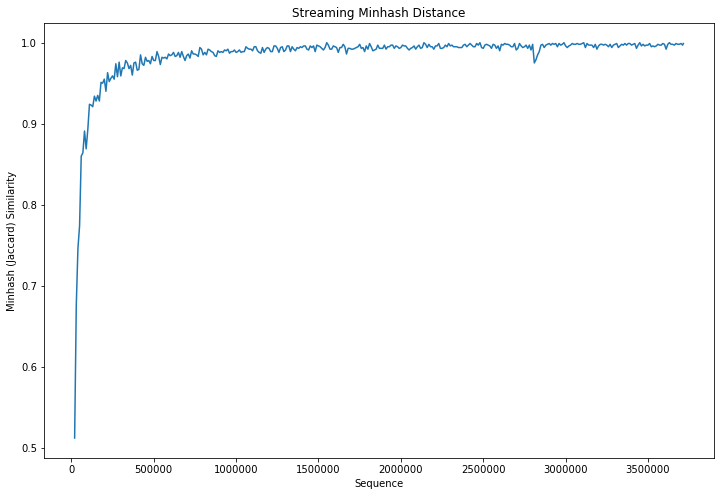

In [14]:
with FigureManager(show=True, figsize=(12,8)) as (fig, ax):
    sns.lineplot(times_small, distances_small, ax=ax)
    ax.set_title('Streaming Minhash Distance')
    ax.set_xlabel('Sequence')
    ax.set_ylabel('Minhash (Jaccard) Similarity')

We can see that the similarity saturates at ~2 million sequences, with the exception of a dip later on -- this could be an instrument error. If we increase the size of the signature, the saturation curve will smooth out.

In [15]:
distances_large, times_large, mh_large = sourmash_stream('ecoli.1.fastq.gz', 'ecoli.2.fastq.gz', N=50000)

250000 reads.
500000 reads.
750000 reads.
1000000 reads.
1250000 reads.
1500000 reads.
1750000 reads.
2000000 reads.
2250000 reads.
2500000 reads.
2750000 reads.
3000000 reads.
3250000 reads.
3500000 reads.


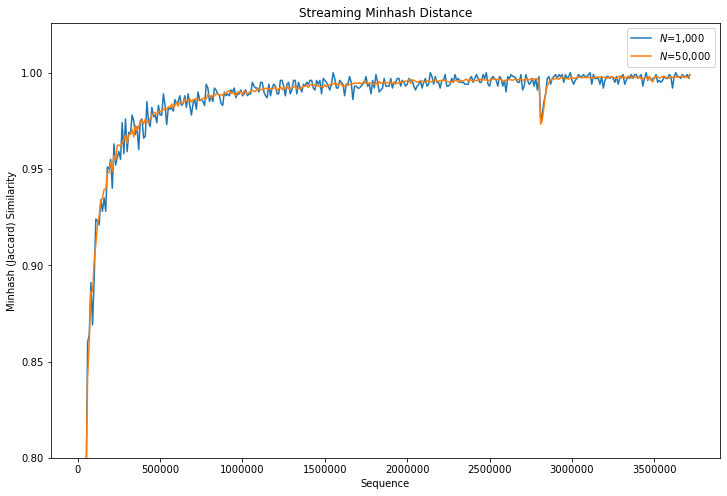

In [16]:
with FigureManager(show=True, figsize=(12,8)) as (fig, ax):
    sns.lineplot(times_small, distances_small, label='$N$=1,000', ax=ax)
    sns.lineplot(times_large, distances_large, label='$N$=50,000', ax=ax)
    ax.set_title('Streaming Minhash Distance')
    ax.set_xlabel('Sequence')
    ax.set_ylabel('Minhash (Jaccard) Similarity')
    ax.set_ylim(bottom=.8)

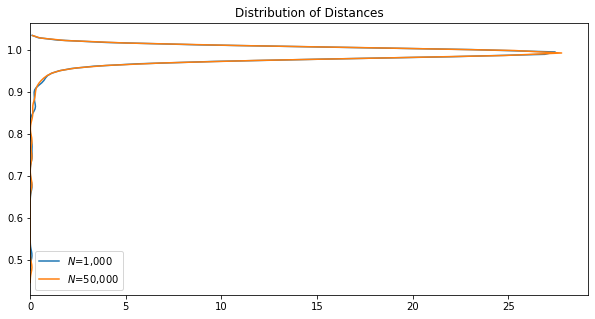

In [17]:
with FigureManager(show=True, figsize=(10,5)) as (fig, ax):
    ax.set_title('Distribution of Distances')
    sns.distplot(distances_small, vertical=True, hist=False, ax=ax, label='$N$=1,000')
    sns.distplot(distances_large, vertical=True, hist=False, ax=ax, label='$N$=50,000')

Smaller minhashes are more susceptible to sequence error, and so the saturation curve is noisy; additionally, the larger minhash detects saturation more clearly, and the distribution of distances leans more heavily toward 1.0.

#### Some Signal Processing

There are a number of metrics we could use to detect "saturation": what exactly we count as such is a user decision. A simplistic approach would be to measure standard deviation of the distance over a window and consider the sample saturated when it drops below a threshold.

In [18]:
def sliding_window_stddev(distances, window_size=10):
    stddevs = np.zeros(len(distances) - window_size + 1)
    for i in range(0, len(distances) - window_size + 1):
        stddevs[i] = np.std(distances[i:i+window_size])
    return stddevs

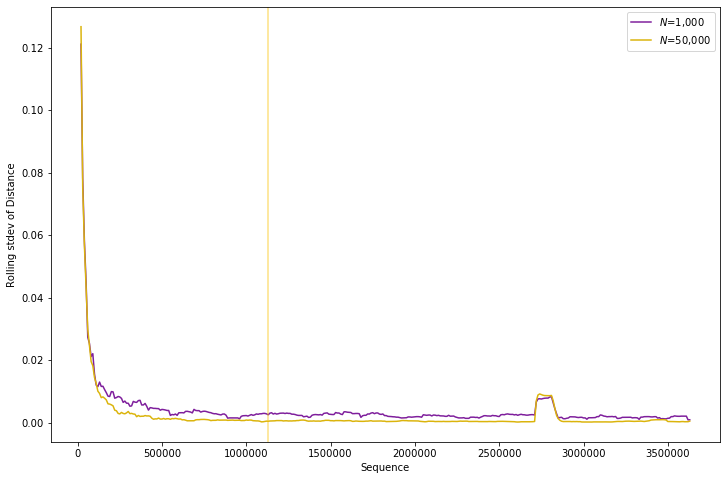

In [19]:
with FigureManager(show=True, figsize=(12,8)) as (fig, ax):
    cutoff = .0005
    window_size = 10
    
    std_small = sliding_window_stddev(distances_small, window_size=window_size)
    sat_small = None
    for i, val in enumerate(std_small):
        if val < cutoff:
            sat_small = i
            break
            
    std_large = sliding_window_stddev(distances_large, window_size=window_size)
    sat_large = None
    for i, val in enumerate(std_large):
        if val < cutoff:
            sat_large = i
            break
    
    ax = sns.lineplot(times_small[:-window_size + 1], std_small, label='$N$=1,000', color=sns.xkcd_rgb['purple'], ax=ax)
    ax = sns.lineplot(times_large[:-window_size + 1], std_large, label='$N$=50,000', ax=ax, color=sns.xkcd_rgb['gold'])
    
    if sat_small is not None:
        ax.axvline(times_small[sat_small + window_size // 2], alpha=.5, color=sns.xkcd_rgb['light purple'],
                   label='$N$=1,000 Saturation')
    if sat_large is not None:
        ax.axvline(times_large[sat_large + window_size // 2], alpha=.5, color=sns.xkcd_rgb['goldenrod'], 
                   label='$N$=50,000 Saturation')
    
    ax.set_ylabel('Rolling stdev of Distance')
    ax.set_xlabel('Sequence')